In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import inspect
import textwrap

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set

import torch.nn.functional as F

In [2]:
#Define the harmonic oscillator

def f(t,x,w):
    #write the function that is on the other side of the differential equation
    return -w*x

def differential_equation_1_order(t, x, w):
    dx_dt = f(t,x,w)
    return dx_dt

def differential_equation_2_order(t, X, w):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,w)

    return [dx_dt, dy_dt]

In [3]:
t_span = (0, 10)
n_steps = 100
n_data = 1000
coeff_test = 0.3

cooling_deq = diffeq(differential_equation_2_order, 2, 1)

train, test = create_trainig_test_set(cooling_deq, t_span, n_steps, n_data, coeff_test, "RK45")
print(train["X"][0].shape)

torch.Size([103])


In [4]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

In [5]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.linear = nn.Linear(in_features=n_step, out_features=200)
        self.linear2 = nn.Linear(200, n_steps)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return x

# Initiate the model
model = CoolingModel(103)

In [6]:
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [7]:
epochs = 20000

for epoch in range(epochs):
    T_pred = model(train["X"])
    
    loss = loss_func(T_pred, train["y_tensor"][0:, 0])

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/100)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 200/20000, Loss: 0.9278
Epoch 400/20000, Loss: 0.9270
Epoch 600/20000, Loss: 0.9263
Epoch 800/20000, Loss: 0.9255
Epoch 1000/20000, Loss: 0.9248
Epoch 1200/20000, Loss: 0.9240
Epoch 1400/20000, Loss: 0.9232
Epoch 1600/20000, Loss: 0.9223
Epoch 1800/20000, Loss: 0.9214
Epoch 2000/20000, Loss: 0.9204
Epoch 2200/20000, Loss: 0.9193
Epoch 2400/20000, Loss: 0.9182
Epoch 2600/20000, Loss: 0.9170
Epoch 2800/20000, Loss: 0.9156
Epoch 3000/20000, Loss: 0.9142
Epoch 3200/20000, Loss: 0.9126
Epoch 3400/20000, Loss: 0.9109
Epoch 3600/20000, Loss: 0.9090
Epoch 3800/20000, Loss: 0.9070
Epoch 4000/20000, Loss: 0.9048
Epoch 4200/20000, Loss: 0.9024
Epoch 4400/20000, Loss: 0.8998
Epoch 4600/20000, Loss: 0.8969
Epoch 4800/20000, Loss: 0.8938
Epoch 5000/20000, Loss: 0.8904
Epoch 5200/20000, Loss: 0.8868
Epoch 5400/20000, Loss: 0.8828
Epoch 5600/20000, Loss: 0.8786
Epoch 5800/20000, Loss: 0.8740
Epoch 6000/20000, Loss: 0.8691
Epoch 6200/20000, Loss: 0.8639
Epoch 6400/20000, Loss: 0.8583
Epoch 6600/2

In [8]:
model.eval()
with torch.no_grad():
    T_pred_test = model(test["X"])
    print(T_pred_test)
    test_loss = loss_func(T_pred_test, test["y_tensor"][0:, 0])
    print(f"Test Loss: {test_loss.item():.4f}")

tensor([[0.5219, 0.5681, 0.6507,  ..., 0.2402, 0.2230, 0.2792],
        [0.4857, 0.5366, 0.6045,  ..., 0.2445, 0.2410, 0.2916],
        [0.5311, 0.5726, 0.6688,  ..., 0.2504, 0.2553, 0.3047],
        ...,
        [0.4631, 0.5157, 0.5495,  ..., 0.1351, 0.1352, 0.1093],
        [0.4740, 0.5243, 0.5739,  ..., 0.1727, 0.1796, 0.1750],
        [0.4624, 0.5196, 0.5522,  ..., 0.1697, 0.1429, 0.1572]])
Test Loss: 0.8831


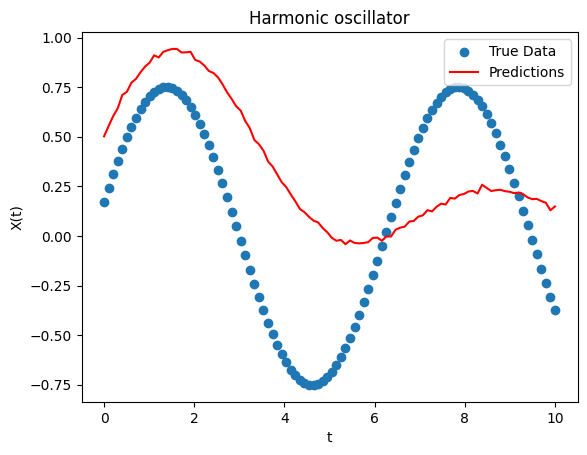

In [11]:
n = 30
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0], label="True Data")
plt.plot(test["t_tensor"][n], T_pred_test[n], color="red", label="Predictions")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Harmonic oscillator")
plt.legend()
plt.show()